# TranSIESTA for electrochemistry

This tutorial was originally created by Dr. Pol Febrer and then adapted by Dr. Ernane Martins for the 2025 edition of the course to include the the QM/MM interface.

This Python notebook guides you through the complete process of **running and post-processing a TranSIESTA simulation with applied voltage**. Our test system is a molecular dynamics (MD) snapshot of liquid water placed between two gold plates (face-centered cubic [111]).

Additionally, you will be introduced to the QM/MM method in SIESTA. First, you will learn the basics using a test system, and then apply it to the same system described above.

**WARNING:** This tutorial is set up with a minimal basis set to ensure it can be executed in serial on a laptop. Other parameters are also chosen for lower precision than would be required in a production run.

## Setting up the environment

To run the tutorial, we have only two requirements: `SIESTA` (the DFT code) and `sisl` (a python package to postprocess outputs).

### Setting up Google Colab

**IMPORTANT**: You only need to run the cells in this section if you are running the tutorial in the google Colab environment.

The first thing we need to do is to set up `conda`, since we will use it to install some dependencies. In Google Colab `conda` is not available by default, so we need to run the following lines:

**NOTE**: Wait for this cell to finish before hitting enter on any other cell, since the conda installation will restart the kernel.

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

Then, to see the plots generated by this notebook, we need to allow Google Colab to run third party widgets (in particular, we will need to display `plotly`'s widgets).

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

### Installing SIESTA



Since `SIESTA` is a fortran code, it can't be installed via pip. There are [multiple ways of building SIESTA](https://docs.siesta-project.org/projects/siesta/en/latest/how-to/index.html#building-siesta). Here we will do it using `conda` due to the simplicity of the process. We only need to tell `conda` to install `SIESTA` from the `conda-forge` channel. In the following cell we use `mamba` instead of `conda` because this is what google colab actually installs, and the installation of `SIESTA` goes much faster. Run the following cell to get `SIESTA` installed with `MPI` parallelization using `OpenMPI`.

*If you are using `conda`, substitute `mamba` by `conda`.*

In [ ]:
! mamba install -c conda-forge "siesta=*=*openmpi*"

### Installing `sisl`

Installing `sisl` is as simple as telling `pip` to do so. We add the `[viz]` requirement to let `pip` know that we want to install the package with all its visualization dependencies.

You can also install `sisl` with `conda` if you wish.

In [1]:
! pip install sisl[viz]

### Getting the input files.

In this section we will download all the inputs required to perform the simulations. This includes the pseudopotentials (with `.psf` extension) and the SIESTA input files (with `.fdf` extension), as well as some files that we will use to restart the calculations from an already converged result, to accelerate the tutorial.

All files are contained in a compressed folder that you can download from https://github.com/pfebrer/sisl/releases/download/fake-tag/Electrochemistry_Tutorial.zip. In the next cell we download the zip file with `wget`. 

*Note*: If you are in Google Colab, you should be able to see the downloaded file by clicking on the files tab on the leftmost part of the screen.

In [ ]:
! wget https://github.com/pfebrer/sisl/releases/download/fake-tag/Electrochemistry_Tutorial.zip

Then, we will need to unzip it.

In [ ]:
! unzip Electrochemistry_Tutorial.zip

## Getting familiar with the files.

In this section, we explore the files that we downloaded, to make sure that everything is fine and to get familiar with the inputs of SIESTA.

In [1]:
import sisl
import sisl.viz # Needed to activate the visualization features

from pathlib import Path
# Change the tutorial root path if this is not correct
tutorial_root = Path("/home/ernane/rrr/Electrochemistry_Tutorial")

If you look at the structure of our root directory, you should be able to see five directories, but now let us start only with those two: `electrode` and `device_water`.

In TranSIESTA, our main system is connected to electrodes in which we can control the Fermi levels. These electrodes are included in our main system (`device_water`), but before running our system we need to perform a bulk run of our electrode. This is because the Hamiltonian of the bulk run is used by TranSIESTA to compute the self-energies.

Then, you should also see that the `device_water` folder contains two folders prepared to run two calculations, one at 0V and one at -0.5V.

The folders should contain:
- `*.psf` files: The pseudopotentials that SIESTA uses to account for the core electrons.
- `*.fdf` files: The input files of SIESTA runs. All the options that you can tune in SIESTA (functionals, tolerance thresholds, k-grid, ...) are passed through these files. These files also contain the atomic coordinates and lattice of the system. In the case of the device we have splitted all the options that we want to use in multiple files, but you can check that the main one `device.fdf`, uses `%include` directives to include the contents of the others.
- `*.TSDE` files: Only in the device folders. This file contains a preconverged density matrix so that SIESTA can start from there. The purpose of this is to make the tutorial faster.

The first thing that we will do is to get familiar with the system that we will simulate. In the following cell we print some information of the structure and then plot it:

**NOTE**: If you are in Google Colab and you can't see the plot, rerun the cell to allow third-party widgets in the `Setting up Google Colab` section.

In [297]:
device_QM = sisl.Geometry.read(tutorial_root / "device_water_QM/0V/device.fdf")
# print(device_QM)
device_QM.plot(axes="zx")

As you can see, there are two gold surfaces separated by a ~17 Ang layer of water (40 molecules). The outermost atoms of gold have undergone surface relaxation during the MD, but the first layer has been kept fixed to properly connect with the electrode. In fact, our system itself contains the electrodes. In the next cell we highlight in blue (green) the left (right) electrode.





In [298]:
device_QM.plot(axes="zx", atoms_style=[
    {"atoms": list(range(36)), "color": "blue"},
    {"atoms": list(range(228, 264)), "color": "green"},
  ])

A crucial point in TranSIESTA calculations is that **your system must contain the electrode coordinates as they are in the bulk configuration**. Not only this, but this region should have the **bulk electronic density**. This means that all effects should be screened by the extra layers in your system. If they are not, you should add more layers. In this case, we only add an extra layer (comprised of three atomic layers).

As a compromise between computation time and real life, we have taken quite a small chunk of gold. Each layer of the surface is comprised of a 2x3 supercell of a gold unit cell where the [111] face is pointing in the direction of the `z` axis.

In [299]:
# The .show() shouldn't be necessary, but for some reason Google Colab breaks
# if it is not there.
device_QM.plot().show()

The last important point to make about this snapshot is that **it comes from a molecular dynamics run at -0.5V**.

Regarding our electrode, if you look at the structure (in the `electrode` directory) you will see that it is just a bulk unit cell of Au-fc[111]. If you repeat the cell 2 times in X and 3 times in Y you end up with the electrode in our system. Note that TranSIESTA is not restricted to work with orthogonal cells, we have chosen this just because it is easier to manipulate the system.

In [300]:
electrode = sisl.Geometry.read(tutorial_root / "electrode/electrode.fdf") 
electrode.plot()

## Running the bulk electrode

As discussed previously, before running a TranSIESTA calculation we need a bulk simulation of our electrodes in order to get the bulk Hamiltonian so that the self-energies can be computed. In this case, since both electrodes are the same, we only need to run one calculation. But in general, we need to run one calculation for every unique electrode in our system.

The bulk electrode calculation is a regular `SIESTA` simulation. Therefore, we will need to call the `siesta` executable passing the input file (`electrode.fdf`) either as an argument or as `stdin`. We need to make sure that the final Hamiltonian is stored in a file (`.TSHS` extension). For that we use the `--electrode` flag.

In the following cell we do precisely this, entering first into the `electrode` directory, and also making sure that the output is registered in the `electrode.out` file.

In [ ]:
! cd Electrochemistry_Tutorial/electrode && mpirun -n 4 siesta --electrode < electrode.fdf | tee electrode.out


While it's running, you can take a moment to familiarize with the `electrode.fdf` file, which is heavily commented to explain the reason why each input is used.

Let's now **wait for the electrode calculation to finish** before going on with the notebook. It should be very fast (~half a minute).

## Device calculation

Now that we have the electrode calculated, we will go on and calculate the device, i.e. our system of interest. We will **run the same calculation at 0V and -0.5V**. In TranSIESTA, **before running any finite voltage calculation you need to run first the 0V calculation**. Then, you should put the converged density matrix file (`*.TSDE`) in the directory of your voltage calculation so that TranSIESTA can start from there. In fact, it is advised to increase the voltage in small steps (~0.5V).

**NOTE**: In this case, we provide you with the `*.TSDE` files containing an already converged density matrix at 0V and -0.5V respectively. This is because the system is very big and it might be too long to compute it from scratch. So, keep in mind that in reality these calculations would take longer.

It is important to remember that the **snapshot comes from a MD at -0.5V**, so when we apply a different voltage we will only see **differences that arise from the electronic structure**. If you wanted to see how the molecules behave under another voltage, you'd have to run a MD at that voltage and take a snapshot from it, because this will allow you to see also changes in water's orientation, for example.

### 0 Volt

We will now do our first `TranSIESTA` calculation, albeit not a very exciting one: it will be at 0V. However, it is a very good starting point to get familiar with the inputs that we need to use. `TranSIESTA` is an option inside `SIESTA`, so we will continue to call the `siesta` executable in the same way, although the inputs in the `*.fdf` file will change. In this case, we have the main input, `device.fdf`, which includes the `TS.fdf` file. We have keeped all the options unique to `TranSIESTA` in the `TS.fdf` file so that you can go through it. It is as well heavily commented. The most crucial inputs are:

- `Solutionmethod transiesta`: Instructs `SIESTA` to use NEGF to compute the electronic density.
- `TS.Voltage 0 eV`: Indicates the voltage that we want to apply to our system.
- `TS.ChemPots`: List of the chemical potentials that will be used in the system. They are then described in `TS.ChemPot.<name>`. Note how the definition of the chemical potentials reference `V`, which is the value of `TS.Voltage`. They also contain the integration contours.
- `TS.Elecs`: List of the electrodes used in the system. Each electrode is then defined in `TS.Elec.<name>`, see the comments there to understand everything that we specify about each electrode.

We will now enter the directory of the 0V calculation and run our first `TranSIESTA` simulation:

In [ ]:
! cd Electrochemistry_Tutorial/device_water_QM/0V && mpirun -n 4 siesta device.fdf | tee device.out

### -0.5 Volt

Mimicking what we did for the 0V case, run the -0.5V `TranSIESTA` simulation. Notice that we already provide a converged density matrix (`*.TSDE` file), otherwise you'd have to copy the one from the 0V calculation in the directory of the -0.5V run before submitting it. Notice also that we updated the input for the voltage from `0 eV` to `-0.5 eV` in `TS.fdf`, the rest is exactly the same.

**NOTE**: We are shifting **the bottom electrode**'s electron chemical potential **by -0.25 eV** and the **top electrode by +0.25 eV**

In [ ]:
! cd Electrochemistry_Tutorial/device_water_QM/_0.5V && mpirun -n 4 siesta device.fdf | tee device.out

First, we get the main input files so that `sisl` can retreive the outputs from it:

In [15]:
fdf_QM_0V = sisl.get_sile(tutorial_root / "device_water_QM/0V/device.fdf")
fdf_QM_V = sisl.get_sile(tutorial_root / "device_water_QM/_0.5V/device.fdf")

Let's now define a helper function to get the difference between the -0.5V and 0V case for any grid in general. 

In [13]:
def grid_difference(grid: str, file_1: str, file_2: str):
    """
    Given the name of a grid, returns the difference between the bias and non-bias calculations.
    
    Parameters
    -----------
    grid: str
        The name of the grid, as accepted by `fdfSileSiesta.read_grid`
    """
    return file_1.read_grid(grid) - file_2.read_grid(grid)

Now we will use it to observe the differences. First, we will focus on the total potential:

In [16]:
grid_difference("TotalPotential",fdf_QM_V,fdf_QM_0V).plot(
    plot_geom=False,   axes="z"
).update_layout(yaxis_title="Total Potential difference [eV]")

We can see that the **potential is basically flat on the electrodes, and it drops through the water layer**, as expected.

Let's plot now the difference in charge density. In this case we use [`Grid.smooth`](http://zerothi.github.io/sisl/docs/latest/api/generated/sisl.Grid.html?highlight=grid#sisl.Grid.smooth) to remove some noise inside the liquid water:

In [17]:
grid_difference("Rho", fdf_QM_V, fdf_QM_0V).smooth().plot(
    plot_geom=True, axes="zx"
).update_layout(yaxis_title="Charge difference [q_e]", 
                legend=dict(x=0, y=1.3, xanchor="left", yanchor="top"))

We can clearly see that the **charges are accumulated mainly in the last layer of gold atoms**.

**NOTE:** `GridPlot` averages the non-displayed dimensions. You can add `axes="zy"` to the plot call to see that this is fine in our case because the grid is very flat in the other directions.

Here, we can clearly see two interesting things:
- Adding the voltage introduces **positive charges in the low electronic potential energy** electrode and **negative charges in the high electronic potential energy** electrode, as it should. You can think of this as the capacitor being charged. If you then connect the two plates through a resistance, electrons (negative charges) will flow spontaneously from high to low. (DISCUSS THIS)
- These additional charges are almost **totally located at the first atomic layer**. This further confirms that the 2-layer electrode is a reasonable choice.

This further confirms that charge is mostly 
accumulated in the first layer of atoms, which makes **our approximation of a 2-layer gold electrode quite reasonable**. *Gold is very good at screening!*

# QM/MM | First steps

To move further with the tutorial, especially to connect TranSIESTA and QM/MM, we first need to learn how to use the QM/MM module of SIESTA. In a standard SIESTA compilation (from version `5.4.0`), you can find examples under `/Utils/QMMM-driver/Tests`.

Here, we will practice with two test systems:

1) Water dimer

    In this simple example, we have only 2 water molecules: 1 QM and 1 MM.

2) Liquid water

    In this case, we have a periodic box containing 1 QM and 215 MM water molecules.

## Getting familiar with the files.

In this section, we explore the files related to QM/MM simulations and how they differ from standard SIESTA runs.

If you look at the structure of our root directory, you should see two directories: `water_dimer_QMMM` and `water_liquid_QMMM`.

In QM/MM, we split the system into QM and MM atoms. In SIESTA, this is handled by adding an extra `fdf` input file, which should be named by appending `.siesta` to the name of the standard input file.

Let us take the example of the files inside the `water_dimer_QMMM` folder (the idea is the same for all QM/MM runs in SIESTA):

- `*.psf` files: The pseudopotentials that SIESTA uses to account for the core electrons, same as in a regular SIESTA run.
- `2H2O.fdf` file (executed by the `siesta_qmmm` executable): The main input file for SIESTA runs. Note that this file contains extra flags:
    - `CoulombType ewald`: The method to solve electrostatic interactions, as in classical MD codes. Here we choose Ewald, which includes PBC. A cut-off scheme (non-periodic) is also available.
    - `MM.Cutoff 8.0 Ang`: The cut-off for non-bonded MM-MM interactions, as usual. It is also used as the cut-off for the Ewald sum.
    - `QMMM.Cutoff 8.0 Ang`: The cut-off to define the number of QM-MM real neighbors.
    - Block to add atom types for the QM atoms (analogous to the `block ChemicalSpeciesLabel` in regular SIESTA). In the following example, we have only three QM atoms, so this block has one line per atom. If you have N QM atoms, you will have N lines. **IMPORTANT**: The atom names (OW, HW, etc.) must match those in the `amber.parm` file explained later.
      ```
      %block QM.AtomTypes
      OW
      HW
      HW
      %endblock QM.AtomTypes
      ```
    - `NumberOfMMAtoms 3`: Number of MM atoms in the system.
    - Block to add MM atom coordinates. This is in [PDB](https://www.cgl.ucsf.edu/chimera/docs/UsersGuide/tutorials/pdbintro.html) format. **IMPORTANT**: This block is format-sensitive; if you change the spacing between columns, it will not work.
      ```
      %block MM.Atoms
      ATOM      1  O   HOH     1      0.000  2.500  0.000
      ATOM      2  H1  HOH     1      0.757  3.086  0.000
      ATOM      3  H2  HOH     1     -0.757  3.086  0.000
      %endblock MM.Atoms
      ```

- `2H2O.siesta.fdf` file (executed by the `siesta` executable): The same as `2H2O.fdf`, but with extra flags at the end:
    ```
    QMMM.Enabled T
    QMMM.Driver SIESTA_DRIVER
    QMMM.Driver.Type pipe
    QMMM.Driver.QMRegionFile 2H2O.siesta.coords
    QMMM.Driver.MMChargeFile 2H2O.siesta.pc
    QMMM.Driver.ForceOutFile 2H2O.siesta.forces
    QMMM.Cutoff           8.0000000 Ang
    QMMM.DensityCut       0.0000010 Ang
    QMMM.CoulombType 1
    QMMM.Ewald.rcut       8.0000000 Ang
    WriteXML .false. 
    ```
    These extra flags should be adjusted according to the `SystemLabel` and QM/MM parameters used in the `2H2O.fdf` file.

**IMPORTANT**: The number of QM atoms is taken from the standard `NumberOfAtoms` flag, and the number of MM atoms is taken from the new `NumberOfMMAtoms` flag.


## How to sun SIESTA QM/MM?

### Running
Here, we will run SIESTA using pipes. We provide you with the `run.sh` file to facilitate running SIESTA QM/MM. Let us take a look at this file:

In [391]:
!cat {tutorial_root / "water_dimmer_QMMM/run.sh"}

inp=2H2O

siesta_qmmm < $inp.fdf > $inp.out &

while true
do
  if [ -f start_siesta ]
  then
    rm -f start_siesta
    echo `date` ": running SIESTA now" >> output
    mpirun -n 4 siesta < $inp.siesta.fdf > $inp.siesta.out       
    break
  else
    # If the file does not exist wait a small increment of time
    echo "still waiting for file start_siesta" >> output
    sleep 1
  fi  
done

sleep 30


As you can see, for a given input name, the executable `siesta_qmmm` runs the `$inp.fdf` file in the background. This is the driver code, responsible for moving the atoms and handling all computations related to the MM atoms. Every time a new coordinate is generated, it sends a message to SIESTA via the file `start_siesta`. Then, through the regular `siesta` executable, the `$inp.siesta.fdf` file is read, and SIESTA takes the coordinates from the driver to compute the forces on the QM atoms. SIESTA also computes the QM/MM interaction term (see the provided slides for details). After that, SIESTA sends the computed forces back to the driver code, which then uses these forces, along with those computed for the MM atoms, to update all atomic positions accordingly.

**NOTE**: The driver code (`siesta_qmmm`) runs in serial. It does not require (and does not support) parallelization.

### Parameters needed

The MM atoms in a QM/MM MD simulation move just as they would in any other classical MD. The only difference is that some MM atoms will interact with the QM ones. Therefore, a force field file containing all the necessary parameters is required. Currently, SIESTA includes its own classical MD implementation. In other QM/MM codes, it is common to interface the QM code with an external MM code (this is also planned for SIESTA in the future).

The force field format implemented for the SIESTA MM driver is AMBER. In our tutorial simulations, the only MM atoms are water, so for the MM atoms, we only need to provide parameters for water. Any 3-point water model can be used. Here, we use mTIP3P, which includes Lennard-Jones parameters for H atoms as well.

The `amber.parm` file (provided) contains the parameters for bonds, angles, dihedrals (if present, though not in the case of water), charges for Coulomb interactions, and the $\sigma$ and $\epsilon$ parameters for the Lennard-Jones potential.

You might think that the `amber.parm` file contains information only for MM atoms, but that's not correct! We must also include in the `ljs` block the $\sigma$ and $\epsilon$ parameters for all QM atom types present, since there is a Lennard-Jones interaction between QM and MM atoms. All the other parameters, in fact, refer to MM-MM interactions. For cases where QM and MM atoms are from the same type, you do not need to add anything to the `ljs` block. However, for the last example we will see, where Au atoms are present in the QM part but not in the MM one, we need to add their $\sigma$ and $\epsilon$ parameters in the `ljs` block.

Take a look at this file to understand it better.

## Water dimmer system

Now that we have been introduced to all the new information required for QM/MM runs, let's get familiar with the system we will simulate. In the following cell, we print some information about the structure and then plot it:

In [412]:
water_dimmer = sisl.Geometry.read(tutorial_root / "water_dimmer_QMMM/2H2O.fdf")
# print(water_dimmer)
water_dimmer.plot()

As you can see, only a single water molecule is shown. That's because sisl does not yet handle the QMMM information.

**Question:** Which water molecule is being shown—the QM or the MM one?

<details style="padding: 10px 20px; color: gray">
    <summary>Hint</summary>
        
*Refer to the input files. Also, you can re-run this cell after you complete your simulation by reading the .XV file instead.*
</details>

### Running the QM/MM MD

As discussed previously, you can simply use the provided `run.sh` script to run the simulation. In this example, we are running a Verlet MD for 100 fs on a system containing 2 water molecules: 1 QM and 1 MM. This setup is just for demonstration purposes and is not physically meaningful.

You can execute the following cell, or navigate to the corresponding folder and run the `run.sh` script manually.

In [ ]:
!cd {tutorial_root / "water_dimmer_QMMM"} && sh run.sh

run.sh


### Ploting data from water dimmer QM/MM MD
Although this system is not physically meaningful, we can still plot the generated data. In the next cell, we define a helper function to easily plot the `*.ene` files.

In [413]:
def plot_ene(ene_file: str):
    import numpy as np
    import matplotlib.pyplot as plt
    """
    Plot the energy and temperature from the .ene file.
    
    Parameters
    -----------
    ene_file: str
        Path to the .ene file.
    """
    with open(ene_file, 'r') as f:
        lines = f.readlines()

    # Extract column names from the header (first line)
    header = lines[0]
    col_names = [name for name in header.strip().split()]

    # Skip header and parse data
    data = np.array([list(map(float, line.split())) for line in lines if not line.lstrip().startswith('#')])

    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Plot columns 2 and 3 (K.E. and P.E.) on the left y-axis
    ax1.plot(data[:, 0], data[:, 4], label=col_names[5], color='tab:red', zorder=1)
    ax1.set_xlabel("Time (fs)")
    ax1.set_ylabel("Temperature (K)")

    # Plot column 4 (T.E.) on the right y-axis
    ax2 = ax1.twinx()
    ax2.plot(data[:, 0], data[:, 1], label=col_names[2], color='tab:blue')
    ax2.plot(data[:, 0], data[:, 2], label=col_names[3], color='tab:orange')
    ax2.plot(data[:, 0], data[:, 3], label=col_names[4], color='tab:green')
    ax2.set_ylabel("Energy (eV)")

    # Merge legends from both axes into one
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.title("Temperature and Energies of the Water dimer Simulation")
    plt.tight_layout()
    # plt.show()

    return 


Now, you can execute the folowing cell and see the graphic generated.

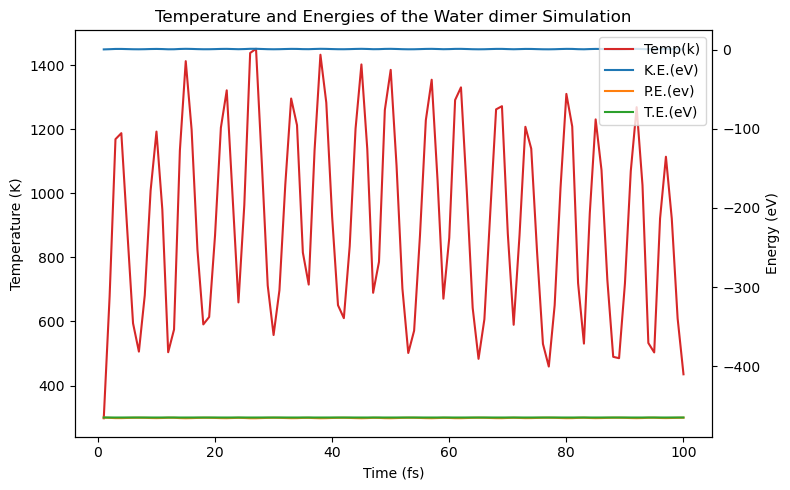

In [414]:
plot_ene(tutorial_root / "water_dimmer_QMMM/2H2O.ene")

This is an NVE (microcanonical) molecular dynamics simulation. As shown in the plot, the total energy is conserved, which becomes more apparent when removing the kinetic energy contribution from the visualization.

## Liquid water system

Now, we will make a second example containing more MM atoms. In this case, we have a water box containing 216 molecules, of which only 1 is treated quantum mechanically (QM). Here we perform an NVT MD for 100 fs. First, let us look at the structure in the following cell.

In [407]:
water_liquid = sisl.Geometry.read(tutorial_root / "water_liquid_QMMM/216_H2O.fdf") #will show the water dimer MM water
# print(water_dimmer)
water_liquid.plot(axes='xz')

As you can see once again, only a single water molecule is shown. That's because sisl does not yet handle the QMMM information.

**Question:** Which water molecule is being shown—the QM or the MM one?

<details style="padding: 10px 20px; color: gray">
    <summary>Hint</summary>
        
*Refer to the input files. Also, you can re-run this cell after you complete your simulation by reading the .XV file instead.*
</details>

### Running the QM/MM MD

Like before, you can simply use the provided `run.sh` script to run the simulation. 

You can execute the following cell, or go directly to the corresponding folder and run the `run.sh` script manually.

In [ ]:
!cd {tutorial_root / "water_liquid_QMMM"} && sh run.sh

run.sh


### Ploting data from water dimmer QM/MM MD

Now, you can run the folowing cell and see the graphic generated.

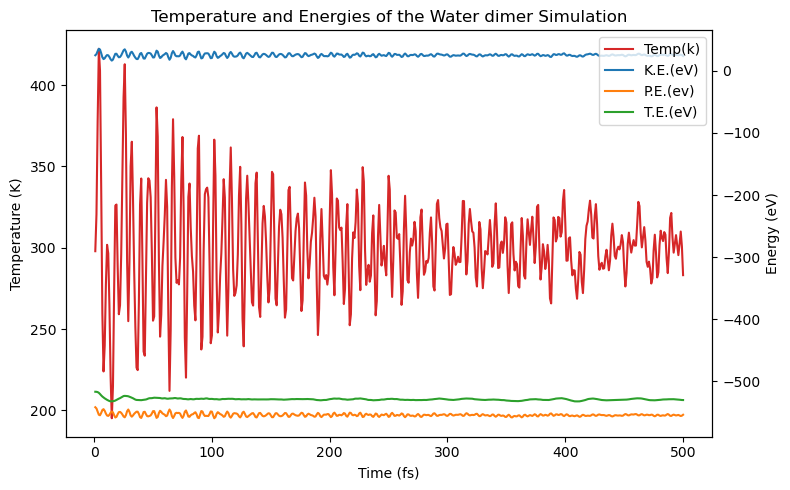

In [382]:
plot_ene(tutorial_root / "water_liquid_QMMM/216_H2O.ene")

This is a more meaningful system, and we could evaluate, for instance, the temperature equilibration. 100 fs is too short for that, of course, but if you run this simulation for longer you could observe more interesting results. In any case, we provide a `216_H2O_500steps.ene` file for a run containing 500 steps, which you can also plot.

**Extra:** You can use your preferred visualization software to view the generated trajectory.

# TranSIESTA + QM/MM for electrochemistry

Now that we were already able to run a QM/MM simulation, we can use the same approach to run a TranSIESTA simulation coupled with the QM/MM. We will use the same Au/water system as before, but this time we will use the QM/MM approach to simulate the water molecules. The very first step is to prepare the QM/MM geometry, which is done in the `device_QMMM` folder. Now, let us read the QM/MM geometry and plot it.


In [3]:
device_QMMM = sisl.Geometry.read(tutorial_root / "device_water_QMMM/0V/device.fdf")
# print(device_QMMM)
device_QMMM.plot(axes="zx")

As you can see, just like before for the water dimer, the MM water is not shown. The system and all of its characteristics are the same as before, and in the following cell we will highlight the electrodes.

<details style="padding: 10px 20px; color: gray">
  <summary>Hint</summary>
    
  *Use the .XV file to make the above plot again once you run is complete.*
</details>

In [4]:
device_QMMM.plot(axes="zx", atoms_style=[
    {"atoms": list(range(36)), "color": "blue"},
    {"atoms": list(range(108, 144)), "color": "green"},
  ])

### Running the bulk electrode

**Question:** Is this needed?

<details style="padding: 10px 20px; color: gray">
  <summary>Hint</summary>
    
  *Recall how we split the system into QM and MM subregions.*
</details>

#### Device calculation

##### 0 Volt

The procedure is the same as before, but now we have a QM/MM system. Therefore, we need to run the 0V and -0.5V calculations just like we did before at the QM level in the beginning.

In the next cell you can see how to run it for 0V.

In [ ]:
!cd {tutorial_root / "device_water_QMMM/0V"} && sh run.sh

run.sh


##### -0.5 Volt

Then, you can do the very same thing for -0.5V.

In [ ]:
!cd {tutorial_root / "device_water_QMMM/_0.5V"} && sh run.sh

run.sh


First, as we did in the QM case, we get the main input files so that `sisl` can retreive the outputs from it:

In [ ]:
fdf_QMMM_0V = sisl.get_sile(tutorial_root / "device_water_QMMM/0V/device.siesta.fdf")
fdf_QMMM_V = sisl.get_sile(tutorial_root / "device_water_QMMM/_0.5V/device.siesta.fdf")

Now, just like before, we can also plot the total potential difference.

In [18]:
grid_difference("TotalPotential",fdf_QMMM_V,fdf_QMMM_0V).plot(
    plot_geom=False,   axes="z" 
).update_layout(yaxis_title="Total Potential difference [eV]")

We can see that the **potential is basically flat on the electrodes**, as expected.

**Question:** Should we expect changes in the Au region if we compare QM and QM/MM potential differences?

<details style="padding: 10px 20px; color: gray">
  <summary>Hint</summary>
    
  *Try to see the potentials for QM and QM/MM for indivual calculations (do not take the differences).*
</details>

Let's plot now the difference in charge density. In this case we use again the [`Grid.smooth`](http://zerothi.github.io/sisl/docs/latest/api/generated/sisl.Grid.html?highlight=grid#sisl.Grid.smooth) to remove some noise inside the liquid water:

In [27]:
grid_difference("Rho", fdf_QMMM_V, fdf_QMMM_0V).smooth().plot(
    plot_geom=True, axes="zx"
).update_layout(yaxis_title="Charge difference [q_e]", 
                legend=dict(x=0, y=1, xanchor="left", yanchor="top"))

We can clearly see that the **charges are accumulated mainly in the last layer of gold atoms**.

**NOTE:** `GridPlot` averages the non-displayed dimensions. You can add `axes="zz"` to the plot call to see that this is fine in our case because the grid is very flat in the other directions.

# Exercise

A nice exercise would be doing the gold slab TranSIESTA calculations again, but without any water molecules (neihter in the QM nor in the MM region) and then compare the results with the ones with water molecules. This would be a good exercise to understand the effect of water molecules (either treated via QM or MM) on the simulations.


# Learned lessons


- We learned the process of running a `TranSIESTA` simulation: First the electrode, then 0V, and then some finite voltage.
- We learned that `TranSIESTA` can correctly simulate the effects caused by water polarization on gold surfaces (metal surfaces in general).
- It can also induce these effects if we apply a voltage drop.
- We learned how to do some post processing of the simulations to observe changes in charge and potential with the applied voltage.
- We learned how to setup and run a QM/MM simulation in SIESTA, and how to couple it with TranSIESTA.

# What now?

If you want to try to run a simulation on your system and you have problems, it is worth it to check the `TranSIESTA` tutorials, which also introduce you to `TBtrans`, a tool to do some further post processing like computing the Density of States:

https://github.com/zerothi/ts-tbt-sisl-tutorial/blob/main/tutorial.ipynb

There are also some useful videos from a recent TranSIESTA school in YouTube:
https://www.youtube.com/@advancedtransiestaschool205/videos

You can ask questions on the discord server of `sisl`, which has a channel specifically for `TranSIESTA`:

https://discord.com/channels/742636379871379577/946145394780418128